In [1]:
# If you are using Anconda, please re-download this file to current directory:
# https://raw.githubusercontent.com/shawnrhoads/gu-psyc-347/master/course-env.yml
# Then, run this cell
# !conda env update --file course-env.yml

In [2]:
# let's begin by importing packages
import pandas as pd, numpy as np, requests
from scipy.stats import truncnorm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns

%matplotlib inline

In [3]:
# setting a fixed seed to our random number generator 
# ensures we will always
# get the same psuedorandom number sequence
np.random.seed(2021)

# Let's set some parameters
beta = -1.75
n_subjects = 131

# Draw x
intercept = 347
x0 = np.ones((n_subjects, 1))

lower, upper = 32, 139 # range of STAB scores 
mu, sigma = 54.9, 30.1 # mean, and standard deviation
x1 = truncnorm.rvs((lower-mu)/sigma,
                   (upper-mu)/sigma,
                   loc=mu,
                   scale=sigma,
                   size=(n_subjects,1))

X = np.hstack((x0, x1))

# sample from a standard normal distribution
noise = np.random.normal(2, 10, (n_subjects,1)) 

# calculate y
y = intercept + beta * x1 + noise

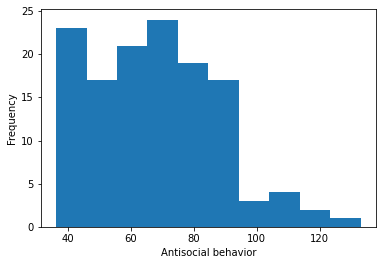

In [4]:
# Plot a histogram
fig, ax = plt.subplots()

ax.hist(x1)
ax.set(xlabel='Antisocial behavior', ylabel='Frequency')
plt.show()

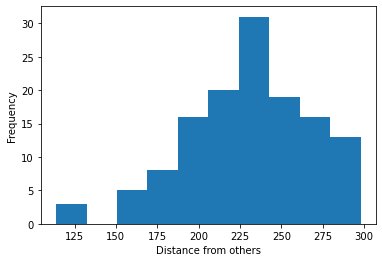

In [5]:
# Plot a histogram
fig, ax = plt.subplots()

ax.hist(y)
ax.set(xlabel='Distance from others', ylabel='Frequency')
plt.show()

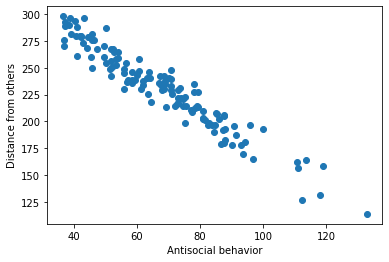

In [6]:
# Plot the results
fig, ax = plt.subplots()
ax.scatter(x1, y)  # produces a scatter plot
ax.set(xlabel='Antisocial behavior', ylabel='Distance from others')
plt.show()

In [7]:
def mse(beta_hats, X, y):
    """Compute the mean squared error

    Args:
    beta_hats (list of floats): A list containing the estimate of the intercept parameter and the estimate of the slope parameter
    X (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding measurement values to the inputs.

    Returns:
    y_hat (float): The estimated y_hat computed from X and the estimated parameter(s).
    mse (float): The mean squared error of the model with the estimated parameter(s).
    """
    
    assert len(beta_hats) == np.shape(X)[1]
    
    # Compute the estimated y
    y_hat = 0
    for index, b in enumerate(beta_hats):
        y_hat += b*X[:,index]
    
    y_hat = y_hat.reshape(len(y_hat),1)
    
    # Compute mean squared error
    mse = np.mean((y - y_hat)**2)

    return y_hat, mse

In [8]:
intercept = 347
possible_betas = [-0.75, -1.75, -2.75]

for beta_hat in possible_betas:
        
    y_hat, MSE_val = mse([intercept, beta_hat], X, y)
    print(f"beta_hat of {beta_hat} has an MSE of {MSE_val:.2f}")

beta_hat of -0.75 has an MSE of 4827.76
beta_hat of -1.75 has an MSE of 111.37
beta_hat of -2.75 has an MSE of 5438.72


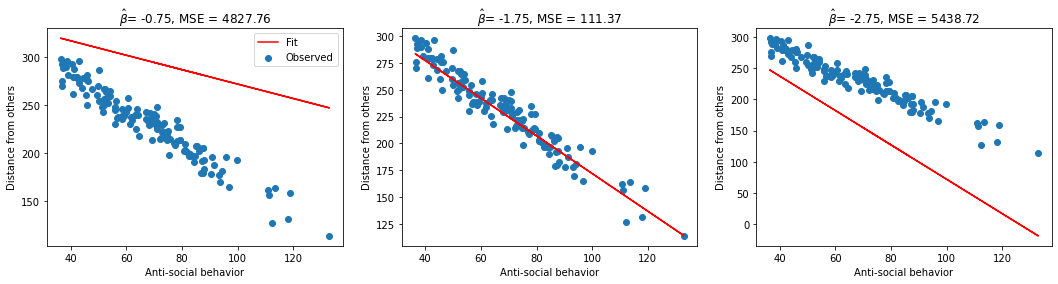

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))

for beta_hat, ax in zip(possible_betas, axes):

    # True data
    ax.scatter(x1, y, label='Observed')  # our data scatter plot

    # Compute and plot predictions
    y_hat, MSE_val = mse([intercept, beta_hat], X, y)

    ax.plot(x1, y_hat, color='r', label='Fit')  # our estimated model

    ax.set(
        title= fr'$\hat{{\beta}}$= {beta_hat}, MSE = {MSE_val:.2f}',
        xlabel='Anti-social behavior',
        ylabel='Distance from others')
    
axes[0].legend()
plt.show()

In [10]:
# interactive display (if not using Jupyter Book)
%config InlineBackend.figure_format = 'retina'
@widgets.interact(beta_hat=widgets.FloatSlider(-1.75, min=-3, max=0),
                  intercept=widgets.FloatSlider(347, min=100, max=400))
def plot_data_estimate(intercept, beta_hat):
    # compute error
    y_hat = (intercept*X[:,0] + beta_hat*X[:,1]).reshape(len(y),1)
    MSE_val = np.mean((y - y_hat)**2)
    
    # plot
    fig, ax = plt.subplots()
    ax.scatter(X[:,1], y, label='Observed')  # our data scatter plot
    ax.plot(X[:,1], y_hat, color='r', label='Fit')  # our estimated model

    # plot residuals
    ymin = np.minimum(y, y_hat)
    ymax = np.maximum(y, y_hat)
    ax.vlines(X[:,1], ymin, ymax, 'g', alpha=0.5, label='Residuals')

    ax.set(
        title=fr"$intercept={intercept:0.2f}, \hat{{\beta}}$ = {beta_hat:0.2f}, MSE = {MSE_val:.2f}",
        xlabel='x',
        ylabel='y')
    
    ax.legend()
    plt.show()

interactive(children=(FloatSlider(value=347.0, description='intercept', max=400.0, min=100.0), FloatSlider(val…

In [11]:
# Exhaustive search 
param_b0 = np.arange(325, 375, 1)
param_b1 = np.arange(-3., 0., .25)

first_run = 'first'
mse_out = []
for b0 in param_b0:
    for b1 in param_b1:
        if first_run is not None:
            first_run = None
            Params = [b0, b1]
        else:
            Params = np.vstack((Params, [b0, b1]))
        mse_out = np.append(mse_out, mse([b0, b1], X, y)[1])

In [12]:
# From out exhaustive search:
# let's see if we can recover the index with the smallest MSE
min_index = np.argmin(mse_out)

print(f'b0, b1 = {Params[min_index]}, MSE = {mse_out[min_index]:.2f}')

b0, b1 = [349.    -1.75], MSE = 105.48


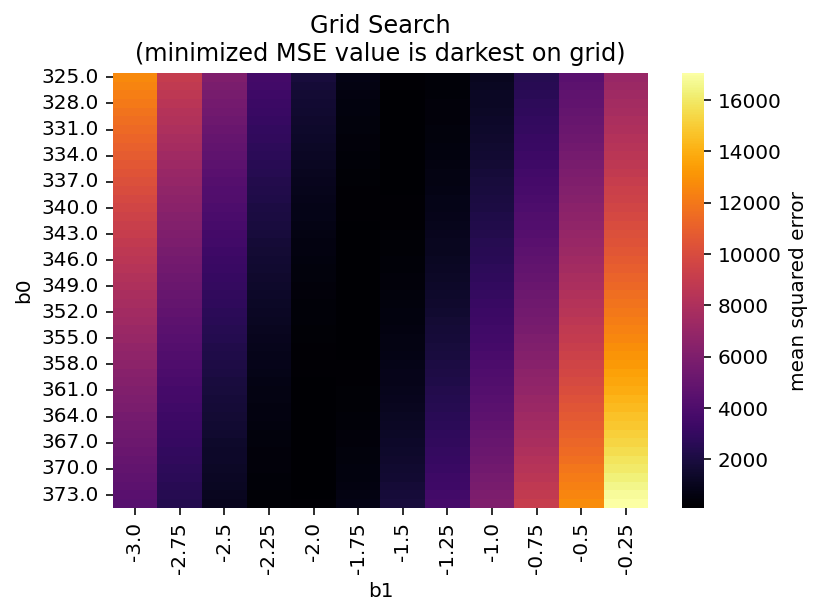

In [13]:
grid_search_data = pd.DataFrame({'b0': Params[:,0],
                                 'b1': Params[:,1], 
                                 'MSE': mse_out})
data_pivoted = grid_search_data.pivot("b0", "b1", "MSE")

sns.heatmap(data_pivoted,
            cmap='inferno',
            cbar_kws={'label': 'mean squared error'})

plt.title("Grid Search\n(minimized MSE value is darkest on grid)")
plt.show()

In [14]:
def mse_to_minimize(beta_hats, X, y):
    """Compute the mean squared error

    Args:
    beta_hats (list of floats): A list containing the estimate of the intercept parameter and the estimate of the slope parameter
    X (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding measurement values to the inputs.
    
    Returns:
    mse (float): The mean squared error of the model with the estimated parameter(s).
    """
    
    assert len(beta_hats) == np.shape(X)[1]
    
    # Compute the estimated y
    y_hat = 0
    for index, b in enumerate(beta_hats):
        y_hat += b*X[:,index]
    
    y_hat = y_hat.reshape(len(y_hat),1)
    
    # Compute mean squared error
    mse = np.mean((y - y_hat)**2)

    return mse

In [15]:
def plot_observed_vs_predicted(beta_hats, X, y):
    """ Plot observed vs predicted data

    Args:
    x (ndarray): observed x values
    y (ndarray): observed y values
    y_hat (ndarray): predicted y values
    beta_hats (ndarray): An array of shape (betas,) that contains the estimate of the slope parameter(s)

    """
    y_hat, MSE_val = mse(beta_hats, X, y)
    
    fig, ax = plt.subplots()
    ax.scatter(X[:,1], y, label='Observed')  # our data scatter plot
    ax.plot(X[:,1], y_hat, color='r', label='Fit')  # our estimated model

    # plot residuals
    ymin = np.minimum(y, y_hat)
    ymax = np.maximum(y, y_hat)
    ax.vlines(X[:,1], ymin, ymax, 'g', alpha=0.5, label='Residuals')

    ax.set(
        title=fr"$intercept={beta_hats[0]:0.2f}, \hat{{\beta}}$ = {beta_hats[1]:0.2f}, MSE = {MSE_val:.2f}",
        xlabel='x',
        ylabel='y')
    
    ax.legend()
    plt.show()

b0, b1 = [352.01054797  -1.78736471], MSE = 104.68617090696347


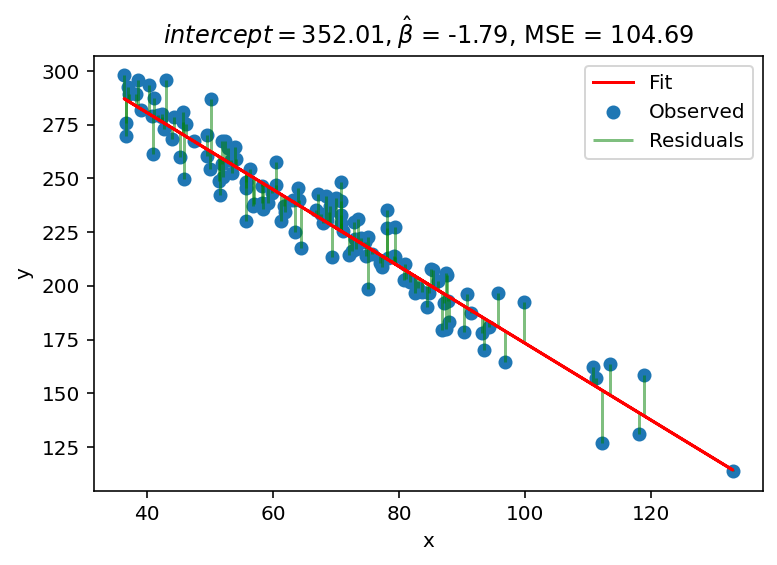

In [16]:
# minimize MSE using scipy.optimize.minimize
res = minimize(mse_to_minimize, # objective function
               (350, -1.75), # estimated starting points
               args=(X, y)) # arguments

print(f'b0, b1 = {(res.x)}, MSE = {res.fun}')
plot_observed_vs_predicted([res.x[0], res.x[1]], X, y)

In [17]:
def ordinary_least_squares(X, y):
    """Ordinary least squares estimator for linear regression.

    Args:
    X (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

    Returns:
    ndarray: estimated parameter values of shape (n_regressors)
    """

    # Compute beta_hat using OLS
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

    return beta_hat

In [18]:
# Compute beta_hat
beta_hat2 = ordinary_least_squares(X, y)
print(f"b0={beta_hat2[0]}, b1={beta_hat2[1]}")

# Compute MSE
y_hat2 = X @ beta_hat2
print(f"MSE = {np.mean((y - y_hat2)**2):.2f}")

b0=[352.0105366], b1=[-1.78736455]
MSE = 104.69


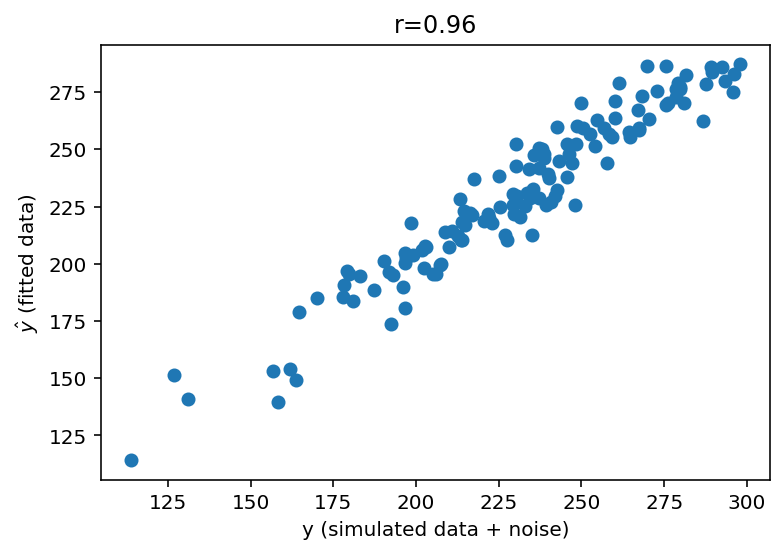

In [19]:
# correlate y and y_hat
corrcoef = np.corrcoef(y.flatten(),y_hat2.flatten())[0,1]

# Plot the results
fig, ax = plt.subplots()
ax.scatter(y, y_hat2)  # produces a scatter plot
ax.set(xlabel='y (simulated data + noise)', ylabel=fr'$\haty$ (fitted data)')
plt.title((f'r={corrcoef:.2f}'))
plt.show()

In [20]:
from scipy import stats
stat_res = stats.linregress(X[:,1],y[:,0])

y_hat_new = (stat_res.intercept + stat_res.slope*X[:,1]).reshape((len(y),1))

print(f'b1 = {stat_res.slope:.2f} , b0 = {stat_res.intercept:.2f}, MSE = {np.mean((y - y_hat_new)**2):.2f}')

b1 = -1.79 , b0 = 352.01, MSE = 104.69


In [21]:
# Let's add age
np.random.seed(2021)

b1 = -1.84
b2 = -.68

lower2, upper2 = 21, 65 # range of ages
mu2, sigma2 = 36.34, 10.08 # mean and standard deviation
x2 = np.random.normal(mu2, sigma2,
                      size=(n_subjects,1))

X_a = np.hstack((x0, x1, x2))

# sample from a standard normal distribution
noise = np.random.normal(2, 10, (n_subjects,1)) 

y_a = (b0 + b1*x1 + b2*x2 + noise).reshape((n_subjects,1))

In [22]:
# Compute beta_hat
beta_hat3 = ordinary_least_squares(X_a, y_a)
print(f"b0={beta_hat3[0]}, b1={beta_hat3[1]}, b2={beta_hat3[2]}")

# Compute MSE
y_hat3 = (X_a @ beta_hat3)
print(f"MSE = {np.mean((y_a - y_hat3)**2):.2f}")

b0=[374.49097358], b1=[-1.81811949], b2=[-0.6804654]
MSE = 101.97
